In [1]:
import os
import itertools
import json
import tqdm
import yaml
from enum import Enum

import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torchvision.transforms.functional as F

from omegaconf import OmegaConf
from pathlib import Path
from tqdm.auto import tqdm
from dal_toolbox.utils import seed_everything
from dal_toolbox.datasets.utils import FeatureDatasetWrapper
from dal_toolbox.datasets.cifar import CIFAR10Plain

os.makedirs('./learning_curves', exist_ok=True)

base_results_path = os.path.join(os.sep, "mnt", "stud", "home", "ynagel", "dal-toolbox", "results", "al_baselines")
hparams_result_path = os.path.join(os.sep, "mnt", "stud", "home", "ynagel", "dal-toolbox", "results", "xpal_hparams")

/mnt/stud/home/ynagel/dal-toolbox/venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_json(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

def load_results(path):
    path = Path(path)
    assert path.is_dir(), 'Path does not exist.'
    exp_json = path / 'results.json'
    results = load_json(exp_json)
    return results

def load_args(path):
    path = Path(path)
    assert path.is_dir(), 'Path does not exist.'
    exp_cfg = path / '.hydra' / 'config.yaml'
    cfg =  OmegaConf.load(exp_cfg)
    return cfg

def load_checkpoint(path, final=True):
    path = Path(path)
    assert path.is_dir(), 'Path does not exist.'
    if final:
        exp_pth = path / 'model_final.pth'
    else:
        exp_pth = path / 'checkpoint.pth'
    checkpoint = torch.load(exp_pth)
    return checkpoint

def get_experiments(result_path, glob_pattern, train_results=False):
    # Aggregate results over multiple glob pattern such as seeds
    experiments = []
    for exp_path in result_path.glob(glob_pattern):
        d = load_results(exp_path)
        experiments.append(d)
    assert len(experiments) != 0, f'No experiments found for {result_path}.'
    return experiments

def create_results_path(dataset, model, strategy, budget):
    return Path(os.path.join(base_results_path, dataset, model, strategy, f"budget_{budget}"))

def xpal_haparams_new_stand_path(kernel, gamma="", alpha=""):
    return Path(os.path.join(hparams_result_path, "CIFAR10", f"pwc_{alpha}_standardized", "xpal", "budget_100", kernel, gamma))

def xpal_haparams_new_path(kernel, gamma="", alpha=""):
    return Path(os.path.join(hparams_result_path, "CIFAR10", f"pwc_{alpha}", "xpal", "budget_100", kernel, gamma))

def xpal_haparams_path(kernel, gamma=""):
    return Path(os.path.join(hparams_result_path, "CIFAR10", "pwc", "random", "budget_100", kernel, gamma))

def xpal_haparams_standardized_path(kernel, gamma=""):
    return Path(os.path.join(hparams_result_path, "CIFAR10_standardized", "pwc", "random", "budget_100", kernel, gamma))

In [3]:
def generate_learning_curves(experiments):
    learning_curves = {}
    for exp_name, path in experiments.items():
        seed_results = get_experiments(Path(path), glob_pattern='seed*')
    
        seed_accuracies = []
        seed_num_labeled = []
        for results in seed_results:
            seed_accuracies.append([val['test_stats']['accuracy'] for key, val in results.items()])
            seed_num_labeled.append([val['n_labeled_samples'] for key, val in results.items()])
        metrics = {
            'acc': np.mean(seed_accuracies, axis=0), 
            'acc_std': np.std(seed_accuracies, axis=0), 
            'num_labeled': np.mean(seed_num_labeled, axis=0)
        }
        learning_curves[exp_name] = metrics
    return learning_curves

def plot_learning_curves(learning_curves, plot_std=True, title="", save=True, savePath=None, loc="best"):
    plt.figure(figsize=(7, 5))
    for exp_name, metrics in learning_curves.items():
        plt.plot(metrics['num_labeled'], metrics['acc'], '-o', label=exp_name)
        if plot_std:
            plt.fill_between(metrics['num_labeled'], metrics['acc'] - metrics['acc_std'], metrics['acc'] + metrics['acc_std'], alpha=.5)
    plt.title(title)
    plt.xlabel('Number of Annotations')
    plt.ylabel('Accuracy')
    plt.legend(loc=loc)
    plt.tight_layout()

    if save:
        assert savePath is not None, "savePath has to be specified when saving image"
        plt.savefig(savePath)

    plt.show()

In [4]:
class Dataset(Enum):
    CIFAR10 = "CIFAR10"

class Model(Enum):
    PWC = "pwc"
    PWC_Standardized = "pwc_standardized"
    Linear = "linear"

class Strategy(Enum):
    Random = "random"
    Entropy = "entropy"
    TypiClust = "typiclust"
    CoreSet = "coreset"
    XPAL = "xpal"
    XPAL_NONE = "xpal_None"

budgets = [100, "100_acq_1"]

## XPAL Comparison

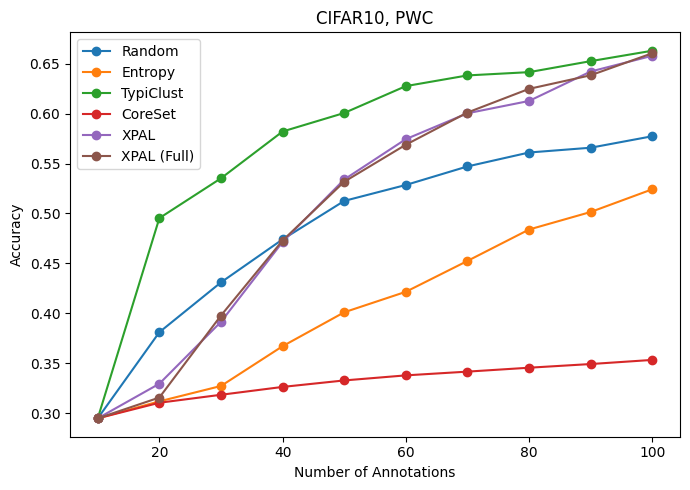

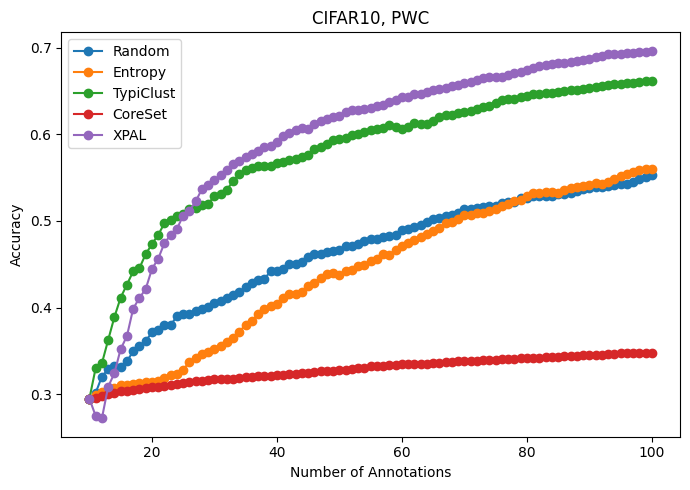

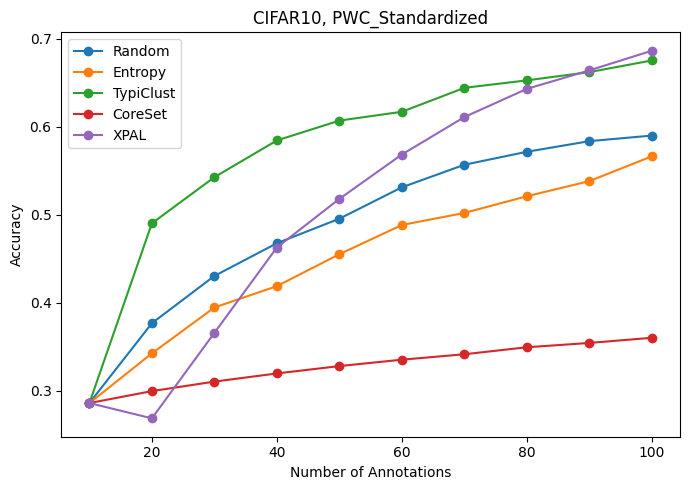

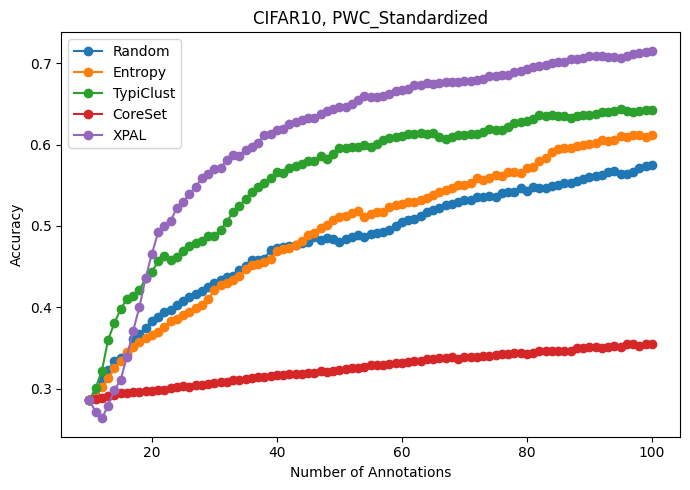

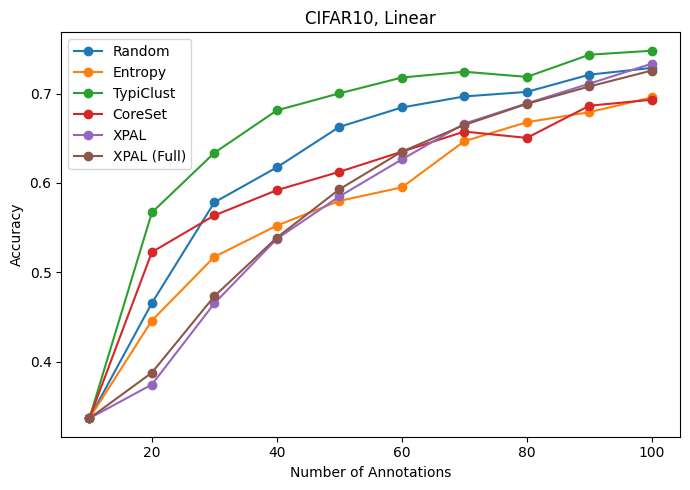

In [5]:
# Generating XPAL Comparison

lp = itertools.product(Dataset, Model, budgets)

for dataset, model, budget in lp:
    dataset_name = dataset.name
    model_name = model.name

    dataset = dataset.value
    model = model.value

    if budget == "100_acq_1" and model == Model.Linear.value:
        continue

    experiments = {
        "Random": create_results_path(dataset ,model, Strategy.Random.value, budget),
        "Entropy": create_results_path(dataset, model, Strategy.Entropy.value, budget),
        "TypiClust": create_results_path(dataset, model, Strategy.TypiClust.value, budget),
        "CoreSet": create_results_path(dataset, model, Strategy.CoreSet.value, budget),
        "XPAL": create_results_path(dataset, model, Strategy.XPAL.value, budget),
        "XPAL (Full)": create_results_path(dataset, model, Strategy.XPAL_NONE.value, budget)
    }

    if budget == "100_acq_1" or model == Model.PWC_Standardized.value:
        del experiments["XPAL (Full)"]

    savePath = Path(os.path.join("learning_curves", dataset, model, f"budet{budget}.png"))
    os.makedirs(os.path.join("learning_curves", dataset, model), exist_ok=True)

    try:
        plot_learning_curves(generate_learning_curves(experiments), title = f"{dataset_name}, {model_name}", save=True, savePath=savePath, plot_std=False)
    except FileNotFoundError as e:
        print(e)

## XPAL Hparams

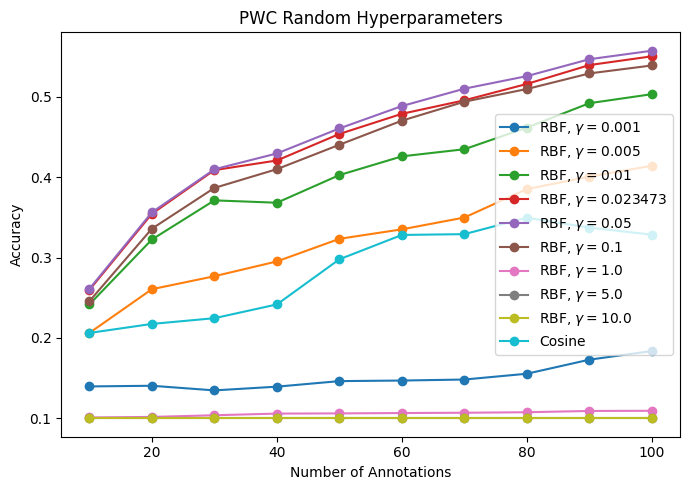

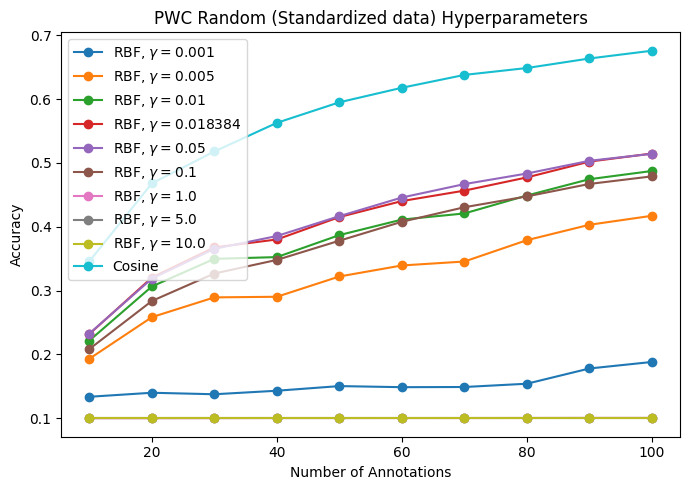

In [6]:
rbf_gammas = (0.001, 0.005, 0.01, 0.023473, 0.05, 0.1, 1.0, 5.0, 10.0)

experiments = {"RBF, $\gamma=$" + str(gamma):xpal_haparams_path("rbf", str(gamma)) for gamma in rbf_gammas}
experiments["Cosine"] = xpal_haparams_path("cosine")

try:
    plot_learning_curves(generate_learning_curves(experiments), title = "PWC Random Hyperparameters", save=True, savePath=savePath, plot_std=False)
except FileNotFoundError as e:
    print(e)

rbf_gammas = (0.001, 0.005, 0.01, 0.018384, 0.05, 0.1, 1.0, 5.0, 10.0)

experiments = {"RBF, $\gamma=$" + str(gamma):xpal_haparams_standardized_path("rbf", str(gamma)) for gamma in rbf_gammas}
experiments["Cosine"] = xpal_haparams_standardized_path("cosine")

try:
    plot_learning_curves(generate_learning_curves(experiments), title = "PWC Random (Standardized data) Hyperparameters", save=False, plot_std=False)
except FileNotFoundError as e:
    print(e)

In [7]:
rbf_gammas = (0.001, 0.005, 0.01, "calculate", 0.05, 0.1, 1.0, 5.0, 10.0)
alphas= ("1e-3", "1e-5", "1e-7", "1e-9", "1e-10", "1e-11", "1e-12", "1e-16")

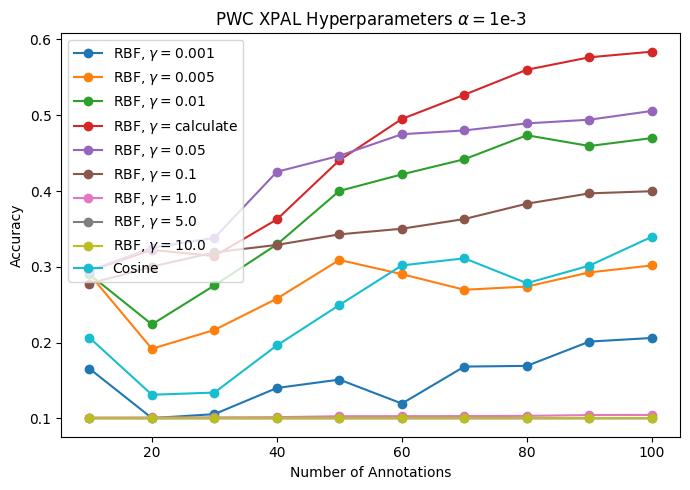

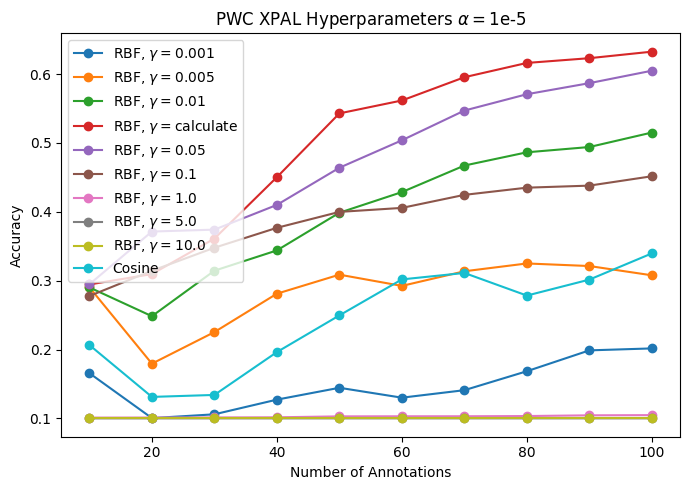

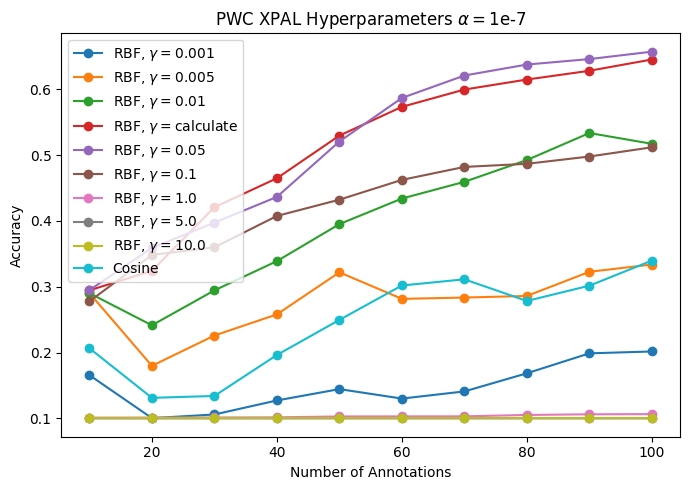

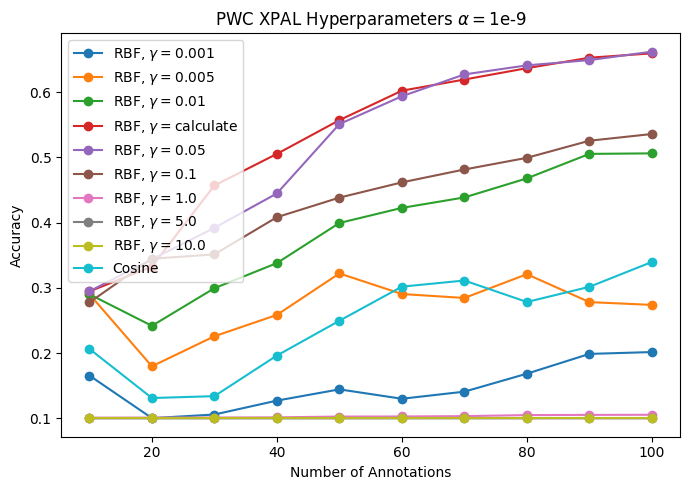

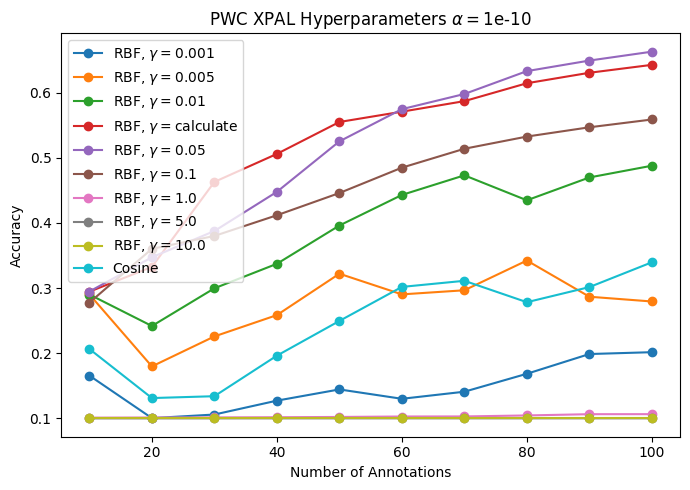

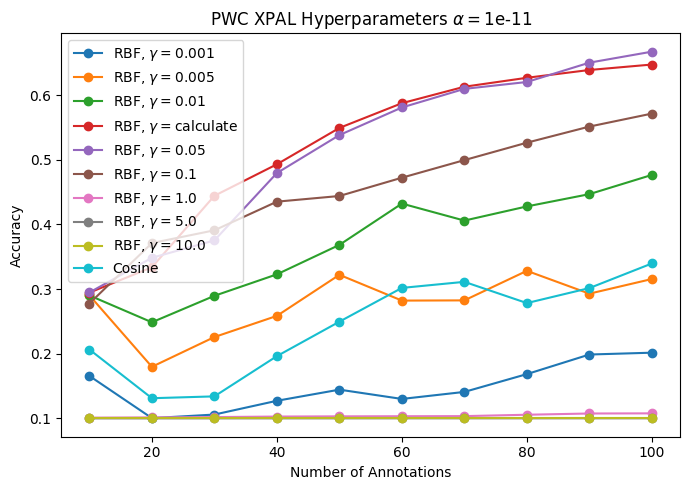

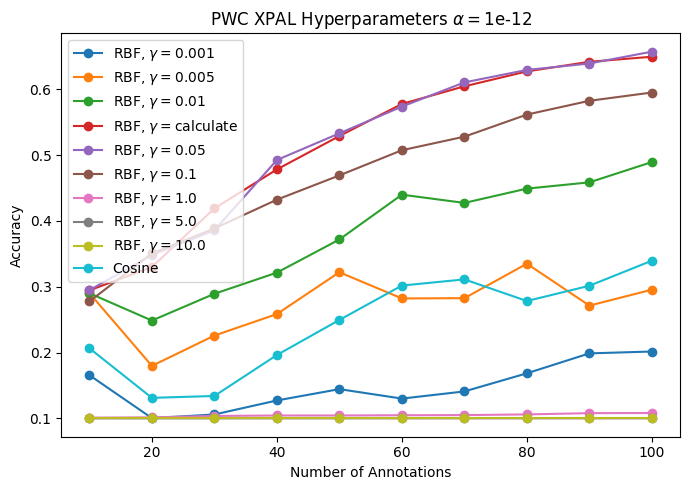

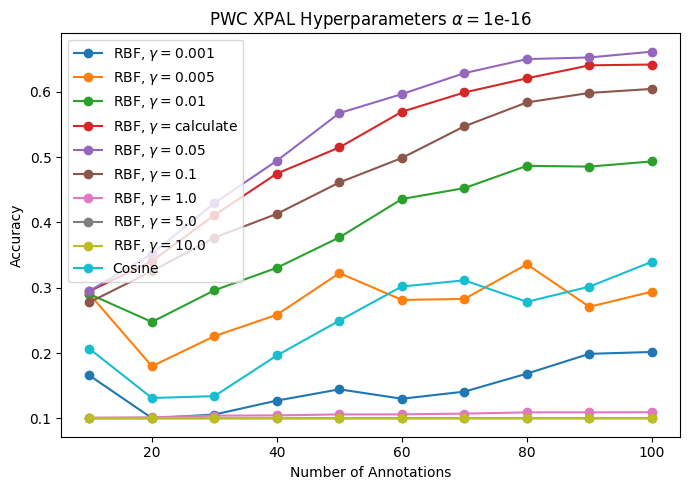

In [8]:
for alpha in alphas:
    experiments = {f"RBF, $\gamma=${str(gamma)}":xpal_haparams_new_path("rbf", str(gamma), alpha) for gamma in rbf_gammas}
    experiments.update({f"Cosine":xpal_haparams_new_path("cosine", alpha=alpha)})
    
    try:
        plot_learning_curves(generate_learning_curves(experiments), title = f"PWC XPAL Hyperparameters $\\alpha=${alpha}", save=False, plot_std=False)
    except FileNotFoundError as e:
        print(e)

In [9]:
experiments = {f"RBF, $\gamma=${str(gamma)}, $\\alpha=${alpha}":xpal_haparams_new_path("rbf", str(gamma), alpha) for gamma in rbf_gammas for alpha in alphas}
exps = generate_learning_curves(experiments)

_max = None
max_acc = 0
for key, value in exps.items():
    if value["acc"][-1] > max_acc:
        _max = key
        max_acc = value["acc"][-1]

print(f"Max final accuracy: {max_acc} reached with_ {_max}")

Max final accuracy: 0.6673199892044067 reached with_ RBF, $\gamma=$0.05, $\alpha=$1e-11


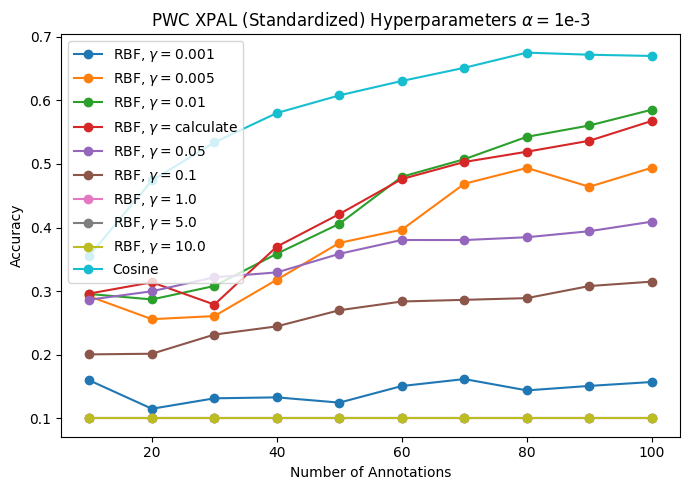

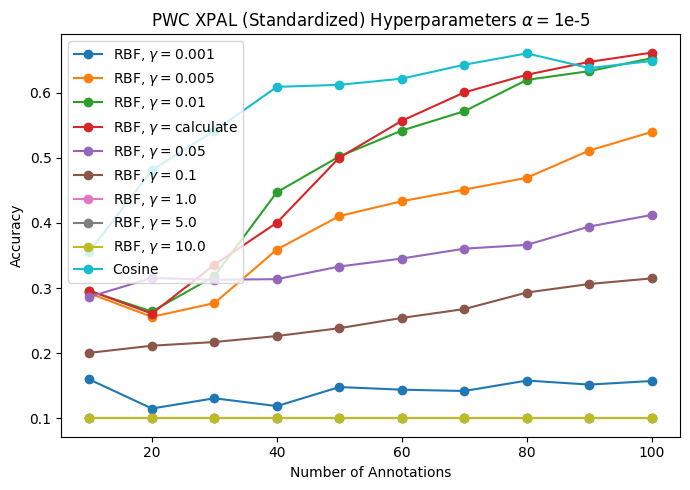

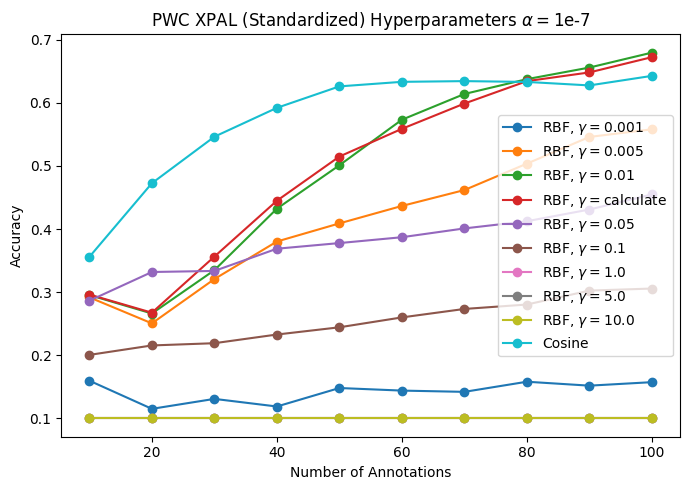

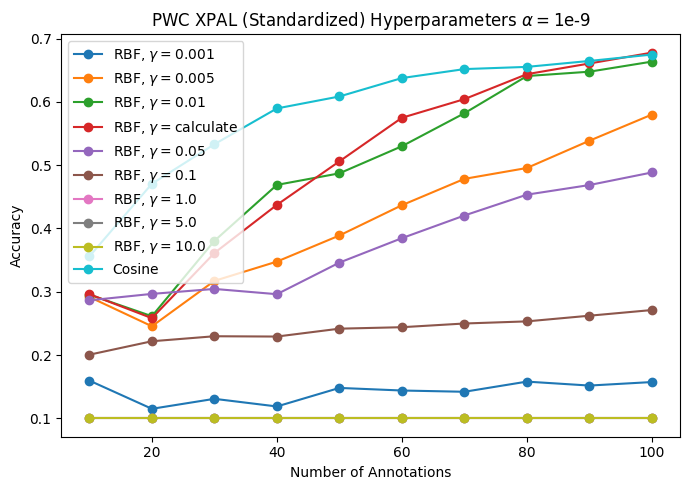

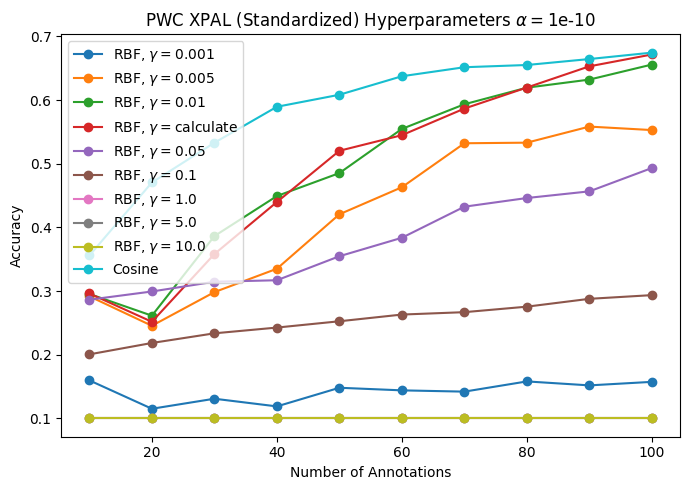

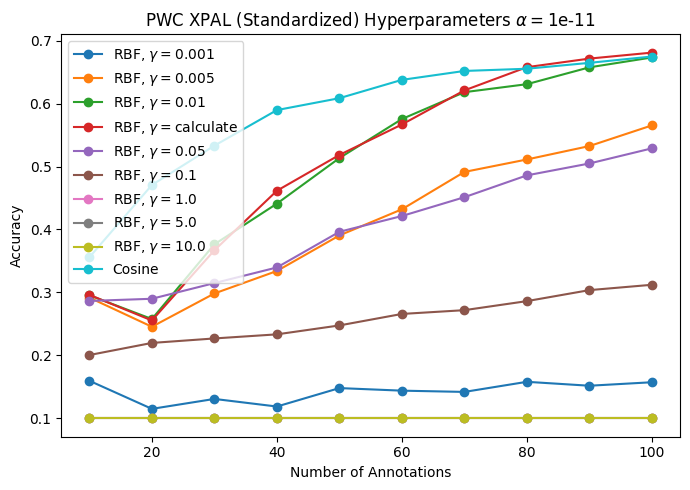

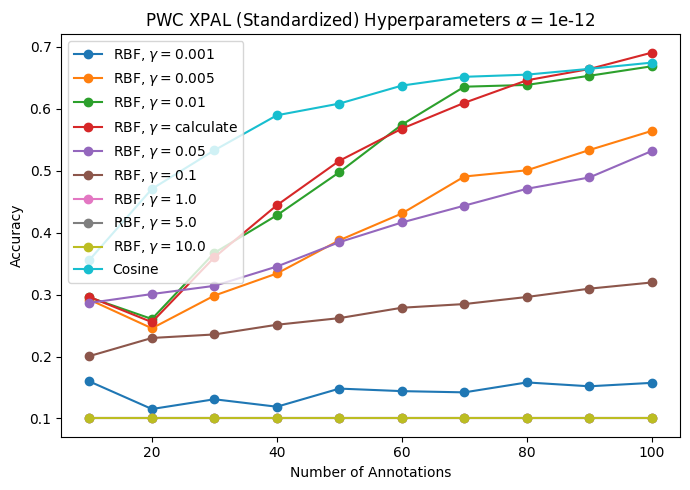

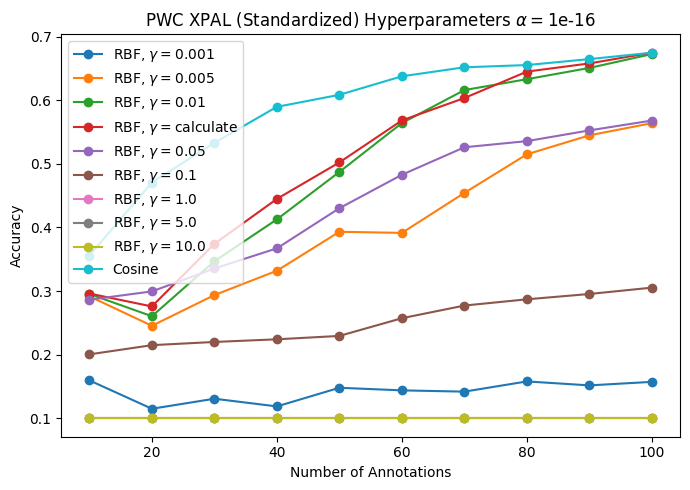

In [10]:
for alpha in alphas:
    experiments = {f"RBF, $\gamma=${str(gamma)}":xpal_haparams_new_stand_path("rbf", str(gamma), alpha) for gamma in rbf_gammas}
    experiments.update({f"Cosine":xpal_haparams_new_stand_path("cosine", alpha=alpha)})
    
    try:
        plot_learning_curves(generate_learning_curves(experiments), title = f"PWC XPAL (Standardized) Hyperparameters $\\alpha=${alpha}", save=False, plot_std=False)
    except FileNotFoundError as e:
        print(e)

In [11]:
rbf_gammas = ("calculate", 0.05)
alphas= ("1e-3", "1e-5", "1e-7", "1e-9", "1e-10", "1e-11", "1e-12", "1e-16")

experiments = {f"RBF, $\gamma=${str(gamma)}, $\\alpha=${alpha}":xpal_haparams_new_stand_path("rbf", str(gamma), alpha) for gamma in rbf_gammas for alpha in alphas}
experiments.update({f"Cosine $\\alpha=${alpha}":xpal_haparams_new_stand_path("cosine", alpha=alpha) for alpha in alphas})

exps = generate_learning_curves(experiments)

_max = None
max_acc = 0
for key, value in exps.items():
    if value["acc"][-1] > max_acc:
        _max = key
        max_acc = value["acc"][-1]

print(f"Max final accuracy: {max_acc} reached with_ {_max}")

Max final accuracy: 0.690779983997345 reached with_ RBF, $\gamma=$calculate, $\alpha=$1e-12


## XPAL vs. TypiClust

In [12]:
features_dir = os.path.join(os.sep, "mnt", "stud", "home", "ynagel", "data", "resnet18_cifar10_87_leacc.pth")
data_dir = os.path.join(os.sep, "mnt", "stud", "home", "ynagel", "data")

cifar_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def show_image_batch(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()

def get_class_distribution_and_images(dataset, model, strategy, budget, seed, features_dir=features_dir):
    # Get data representation and labels
    seed_everything(seed)
    data = FeatureDatasetWrapper(features_dir)
    labels = np.array([int(label) for _, label in data.train_dataset])

    # Getting indices
    res_path = Path(os.path.join(base_results_path, dataset, model, strategy, f"budget_{budget}", f"seed{seed}", "queried_indices.json"))
    indices = load_json(res_path)
    chosen_labels = [labels[val] for val in indices.values()]

    # Getting images # Not working 
    # cifar = CIFAR10Plain(data_dir, seed=42)
    # images = torch.stack([img for img, _ in cifar.train_dataset])
    # chosen_images = [images[val] for val in indices.values()]
    chosen_images = None
    return chosen_labels, chosen_images

[rank: 0] Global seed set to 1
[rank: 0] Global seed set to 1
[rank: 0] Global seed set to 2
[rank: 0] Global seed set to 2
[rank: 0] Global seed set to 3
[rank: 0] Global seed set to 3
[rank: 0] Global seed set to 4
[rank: 0] Global seed set to 4
[rank: 0] Global seed set to 5
[rank: 0] Global seed set to 5
[rank: 0] Global seed set to 6
[rank: 0] Global seed set to 6
[rank: 0] Global seed set to 7
[rank: 0] Global seed set to 7
[rank: 0] Global seed set to 8
[rank: 0] Global seed set to 8
[rank: 0] Global seed set to 9
[rank: 0] Global seed set to 9
[rank: 0] Global seed set to 10
[rank: 0] Global seed set to 10


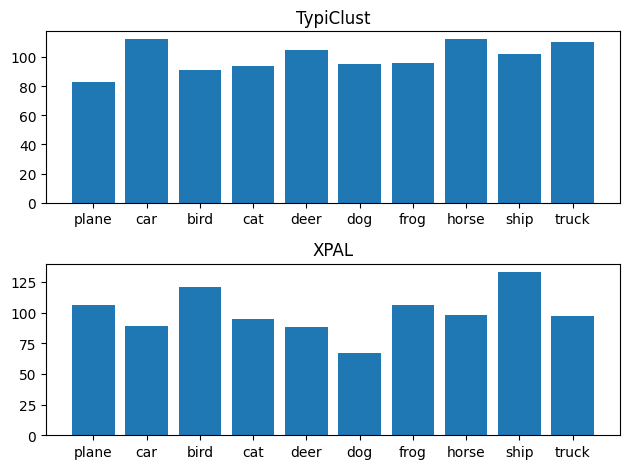

In [13]:
seeds = [i for i in range(1, 11)]

typiclust = np.zeros(10)
xpal = np.zeros(10)

for seed in seeds:
    typi_dist, _ = get_class_distribution_and_images("CIFAR10", "pwc", "typiclust", "100", seed)
    xpal_dist, _ = get_class_distribution_and_images("CIFAR10", "pwc", "xpal", "100", seed)

    for typi_clycle, xpal_cylce in zip(typi_dist, xpal_dist):
        typi_labels, typi_counts = np.unique(typi_clycle, return_counts=True)
        xpal_labels, xpal_counts = np.unique(xpal_cylce, return_counts=True)
    
        typiclust[typi_labels] += typi_counts
        xpal[xpal_labels] += xpal_counts
        
fig, axes = plt.subplots(nrows=2)
labels = np.arange(10)

axes[0].bar(labels, typiclust, align='center')
axes[0].set_xticks([i for i in range(10)], cifar_classes)
axes[0].set_title("TypiClust")
axes[1].bar(labels, xpal, align='center')
axes[1].set_xticks([i for i in range(10)], cifar_classes)
axes[1].set_title("XPAL")
fig.tight_layout()
plt.show()

[rank: 0] Global seed set to 1
[rank: 0] Global seed set to 1
[rank: 0] Global seed set to 2
[rank: 0] Global seed set to 2
[rank: 0] Global seed set to 3
[rank: 0] Global seed set to 3
[rank: 0] Global seed set to 4
[rank: 0] Global seed set to 4
[rank: 0] Global seed set to 5
[rank: 0] Global seed set to 5
[rank: 0] Global seed set to 6
[rank: 0] Global seed set to 6
[rank: 0] Global seed set to 7
[rank: 0] Global seed set to 7
[rank: 0] Global seed set to 8
[rank: 0] Global seed set to 8
[rank: 0] Global seed set to 9
[rank: 0] Global seed set to 9
[rank: 0] Global seed set to 10
[rank: 0] Global seed set to 10


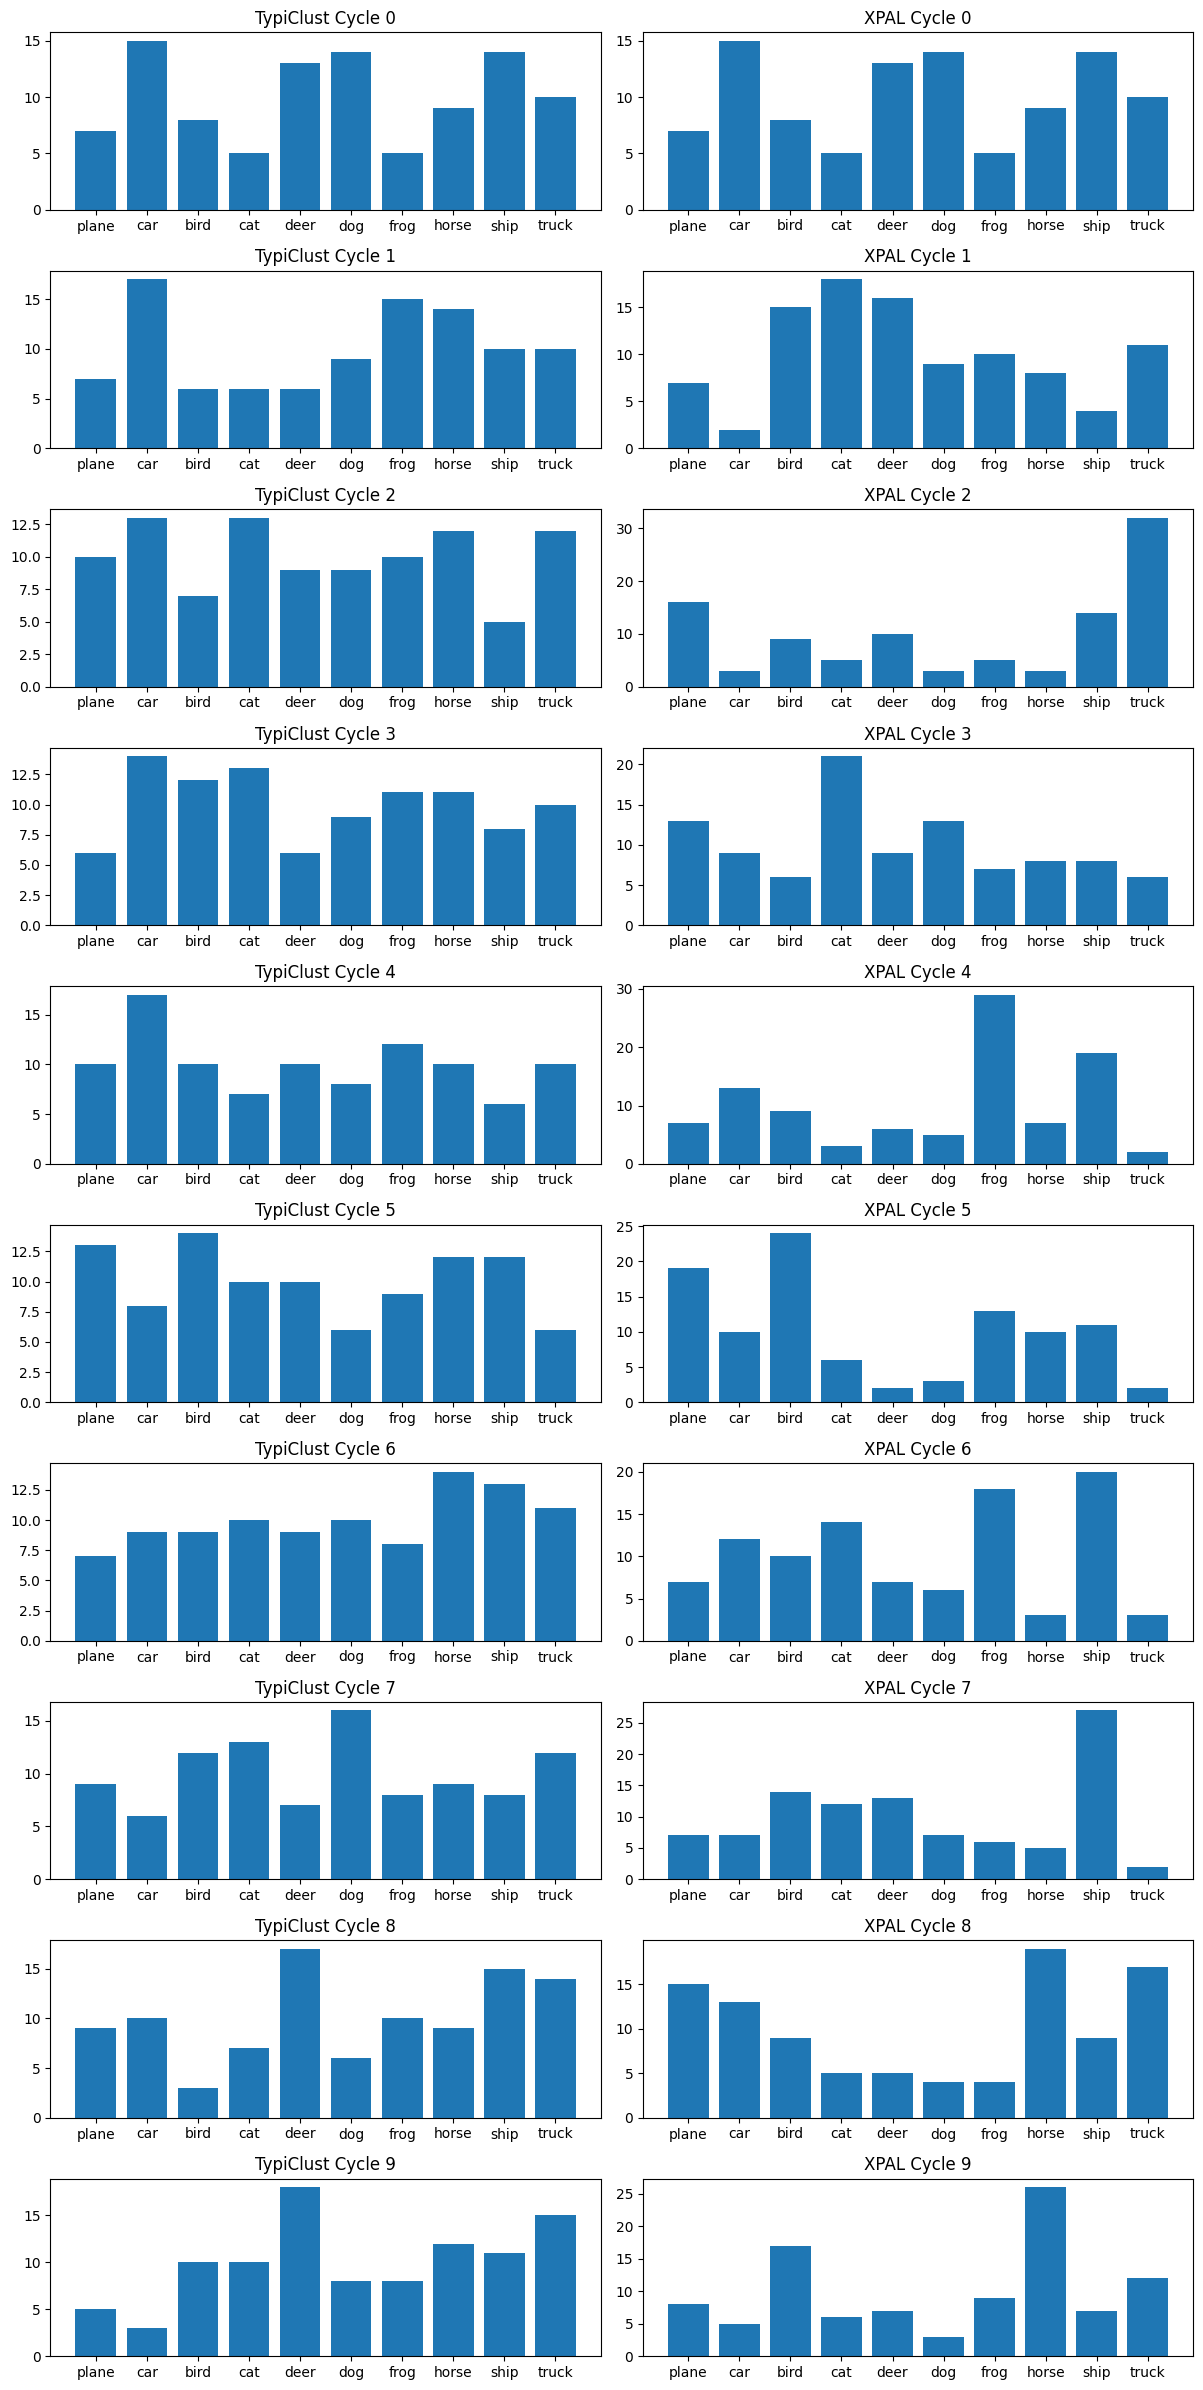

In [14]:
seeds = [i for i in range(1, 11)]

typiclust = [np.zeros(10) for i in range(10)]
xpal = [np.zeros(10) for i in range(10)]

for seed in seeds:
    typi_dist, _ = get_class_distribution_and_images("CIFAR10", "pwc", "typiclust", "100", seed)
    xpal_dist, _ = get_class_distribution_and_images("CIFAR10", "pwc", "xpal", "100", seed)

    for idx, (typi_clycle, xpal_cylce) in enumerate(zip(typi_dist, xpal_dist)):
        typi_labels, typi_counts = np.unique(typi_clycle, return_counts=True)
        xpal_labels, xpal_counts = np.unique(xpal_cylce, return_counts=True)
    
        typiclust[idx][typi_labels] += typi_counts
        xpal[idx][xpal_labels] += xpal_counts

fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(12, 24))
labels = np.arange(10)
for i in range(10):
    axes[i][0].bar(labels, typiclust[i], align='center')
    axes[i][0].set_xticks([i for i in range(10)], cifar_classes)
    axes[i][0].set_title(f"TypiClust Cycle {i}")
    axes[i][1].bar(labels, xpal[i], align='center')
    axes[i][1].set_xticks([i for i in range(10)], cifar_classes)
    axes[i][1].set_title(f"XPAL Cycle {i}")
fig.tight_layout()
plt.show()